# Build 1D model

In [1]:
import sys
sys.path.append("../")
import numpy as np
import temperer
from temperer.forward_modelling import Forward_model

In [2]:
model = temperer.Model()

In [3]:
import pandas as pd
node_template=model.builder.single_node_sediments_inputs_template
h1 = [152.0,0.0,1.500000,2.301755e-09,0.620000,0.500,2720.0,2448.0]
h2=[810.0,20.0,1.538462,2.079433e-09,0.599730,0.490,2708.0,2437.2]
h3=[1608.0,66,1.500000,2.301755e-09,0.2,0.500,2720.0,2448.0]
h4=[1973.0,100,1.500000,2.301755e-09,0.620000,0.500,2720.0,2448.0]
h5=[2262.0,145,1.500000,2.301755e-09,0.620000,0.500,2720.0,2448.0]
h6=[2362.0,152,1.904762,4.719506e-10,0.447705,0.415,2618.0,2356.2]
h7=[2427.0,160,1.500000,2.301755e-09,0.620000,0.500,2720.0,2448.0]
horizons=[h1,h2,h3,h4,h5,h6,h7]
for i in horizons:
    new =pd.DataFrame.from_dict({'top': [i[0]], 'topage': [int(i[1])], 'k_cond': [i[2]], 'rhp':[i[3]], 'phi':[i[4]], 'decay':[i[5]], 'solidus':[i[6]],'liquidus':[i[7]]})
    node_template = pd.concat([node_template, new], ignore_index=True)
   

/tmp/ipykernel_2076/1143012394.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  node_template = pd.concat([node_template, new], ignore_index=True)


Create a single node and add it to the model

In [4]:
node =temperer.single_node()
node.sediments_inputs = node_template
node.sediments

,top,topage,k_cond,rhp,phi,decay,solidus,liquidus,base,baseage,thickness,grain_thickness,phi_mean
0,152.0,0,1.500000,2.301755e-09,0.620000,0.500,2720.0,2448.0,810.0,20,658.0,0.310357,0.528332
1,810.0,20,1.538462,2.079433e-09,0.599730,0.490,2708.0,2437.2,1608.0,66,798.0,0.511062,0.359571
2,1608.0,66,1.500000,2.301755e-09,0.200000,0.500,2720.0,2448.0,1973.0,100,365.0,0.332780,0.088275
3,1973.0,100,1.500000,2.301755e-09,0.620000,0.500,2720.0,2448.0,2262.0,145,289.0,0.221878,0.232256
4,2262.0,145,1.500000,2.301755e-09,0.620000,0.500,2720.0,2448.0,2362.0,152,100.0,0.078943,0.210571
5,2362.0,152,1.904762,4.719506e-10,0.447705,0.415,2618.0,2356.2,2427.0,160,65.0,0.053525,0.176536


In [5]:
model.parameters.time_start=int(node.sediments["baseage"].iloc[-1])
model.parameters.time_end = 0

In [6]:
node.shf = 60e-3
node.qbase = 30e-3
node.rift = np.array([[160,145]])
#node.paleoWD=np.array([200]) # Only for mulit rift

In [7]:
model.builder.nodes = [[node]]

In [8]:
from temperer.data import haq87
model.builder.set_eustatic_sea_level(haq87)

In [9]:
%%time
model.simulator.run(parallel=False)


CPU times: user 654 ms, sys: 63.5 ms, total: 717 ms
Wall time: 613 ms


In [10]:
model.builder.nodes[0][0].beta

array([1.24])

/home/runner/work/temperer/temperer/temperer/postprocessing.py:196: RuntimeWarning: invalid value encountered in divide
  v=-1*initial_poro/initial_decay*phi1


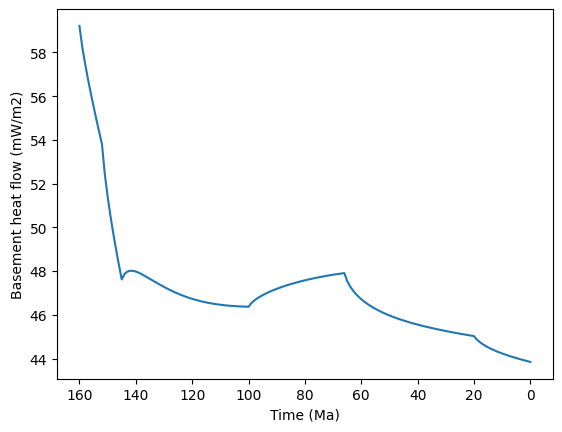

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(node.result.ages,[node.result.basement_heatflow(age)*1000 for age in node.result.ages])
plt.gca().invert_xaxis()
plt.xlabel("Time (Ma)")
plt.ylabel("Basement heat flow (mW/m2)")
plt.show()

In [12]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

def plot_cell_bound(age):
    t = node.result.temperature(age)
    plt.plot(t["values"],t["depth"])
    plt.gca().invert_yaxis()
    plt.xlabel("Temperature (C)")
    plt.ylabel("Depth (m)")
    plt.ylim(top=0,bottom=node.result.temperature(age,-2)["depth"][0]+1000)
    plt.show()

widgets.interact(plot_cell_bound, age = widgets.IntSlider(value=0,max=node.result.ages[-1],min=node.result.ages[0],step=1))

interactive(children=(IntSlider(value=0, description='age', max=160), Output()), _dom_classes=('widget-interac…

<function __main__.plot_cell_bound(age)>

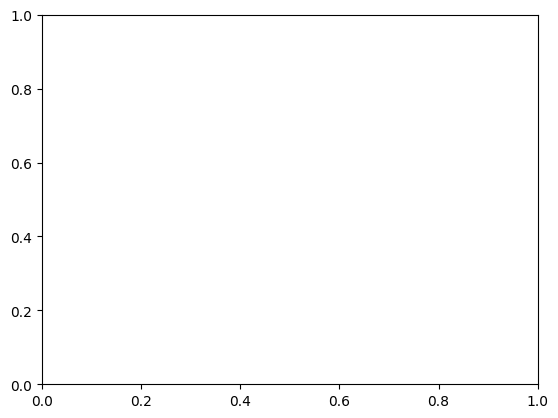

interactive(children=(IntSlider(value=0, description='age', max=160), Output()), _dom_classes=('widget-interac…

<function __main__.plot_cell_properties(age)>

In [13]:
def plot_cell_properties(age):
    t = node.result.effective_conductivity(age)
    plt.plot(t["values"],(t["depth"][1:]+t["depth"][:-1])/2)
    plt.gca().invert_yaxis()
    plt.xlabel("Conductivity")
    plt.ylabel("Depth (m)")
    plt.ylim(top=0,bottom=node.result.temperature(age,-1)["depth"][0])
    plt.show()

widgets.interact(plot_cell_properties, age = widgets.IntSlider(value=0,max=node.result.ages[-1],min=node.result.ages[0],step=1))